Instalar a biblioteca `ultralytics`.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

Criar diretório `geometricShapes` e adicionar as pastas `model` e `images` copiadas do GitHub.

O conteúdo da pasta `model` foi gerado pelo treinamento da rede utilizando este outro Colab:

https://colab.research.google.com/drive/12Tbr06EXiZbHfuUhBymnrOsjyUDB9AUW

As imagens da pasta `images` não foram utilizadas nesse treinamento e serão úteis para testar o modelo treinado.

In [ ]:
!mkdir /content/geometricShapes
!wget https://github.com/fzampirolli/morph/raw/main/Expanded/images.zip -O images.zip
!unzip images.zip -d /content/geometricShapes/

!wget https://github.com/fzampirolli/morph/raw/main/Expanded/model.zip -O model.zip
!unzip model.zip -d /content/geometricShapes/

mkdir: cannot create directory ‘/content/geometricShapes’: File exists
--2024-08-07 20:42:06--  https://github.com/fzampirolli/morph/raw/main/Expanded/images.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fzampirolli/morph/main/Expanded/images.zip [following]
--2024-08-07 20:42:06--  https://raw.githubusercontent.com/fzampirolli/morph/main/Expanded/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104281 (102K) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 101.84K  --.-KB/s    in 0.02s   

2024-08-07 20:42:06 (4.24 MB/s) - ‘images.zip’ sa

Carrega os nomes das classes.

In [ ]:
def load_classes():
    #with open('/data.yaml', 'r') as config_file:
    with open('/content/geometricShapes/model/data.yaml', 'r') as config_file:
        config_data = config_file.read()

    class_names_start = config_data.find("names: [") + len("names: [")
    class_names_end = config_data.find("]", class_names_start)
    class_names_str = config_data[class_names_start:class_names_end]
    class_names = [name.strip().strip("'") for name in class_names_str.split(",")]

    return class_names

nomeClasses = load_classes()

Cores aleatórias das bounding boxes

In [ ]:
import random

def class_colors(names):
    return {name: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for name in names}

color = class_colors(nomeClasses)

In [ ]:
# Caminho para a pasta com as imagens
image_folder = '/content/geometricShapes/images'

# Extensões de imagem suportadas
image_extensions = ['.jpeg', '.jpg', '.png']

Carrega o modelo treinado

In [ ]:
from ultralytics import YOLO

# Carregar o modelo treinado YOLOv8
model = YOLO('/content/geometricShapes/model/best.pt')

Função para realizar a inferência e desenhar as bounding boxes

In [ ]:
import os
import cv2

def process_image(image_path):
    image = cv2.imread(image_path)
    results = model(image)
    return image, results


# Função para desenhar bounding boxes na imagem
def draw_boxes(image, results):
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordenadas da bounding box
            conf = box.conf[0]  # Confiança
            cls = int(box.cls[0])  # Classe
            label = f'{model.names[cls]} {conf:.2f}'  # Rótulo com a classe e confiança

            className = nomeClasses[cls]


            # Desenhar a bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color[className], 1)
            # Desenhar o rótulo
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color[className], 1)

    return image


# Listar todas as imagens na pasta
images = [f for f in os.listdir(image_folder) if os.path.splitext(f)[-1].lower() in image_extensions]

Realiza a inferência em todas as imagens na pasta `images` e exibe o resultado



0: 640x640 1 circle, 1 cross, 1 ellipse, 1 heptagon, 1 hexagon, 1 pentagon, 1 square, 1 star, 1 triangle, 423.1ms
Speed: 34.2ms preprocess, 423.1ms inference, 35.7ms postprocess per image at shape (1, 3, 640, 640)


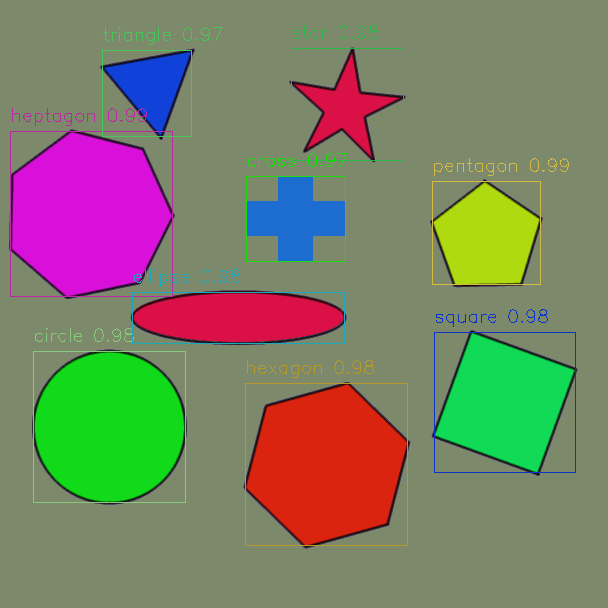


0: 640x640 1 circle, 1 cross, 1 ellipse, 1 heptagon, 1 hexagon, 1 pentagon, 1 square, 1 star, 1 triangle, 359.0ms
Speed: 6.6ms preprocess, 359.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


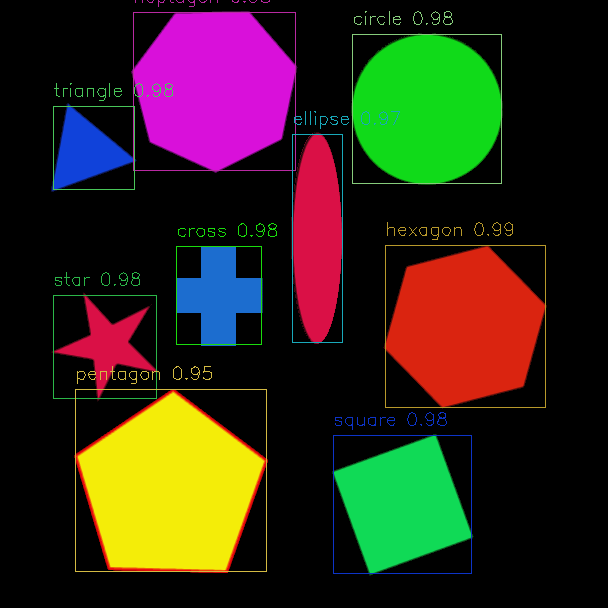


0: 640x640 1 circle, 1 cross, 1 ellipse, 1 heptagon, 1 hexagon, 1 pentagon, 1 square, 1 star, 1 triangle, 330.0ms
Speed: 5.2ms preprocess, 330.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


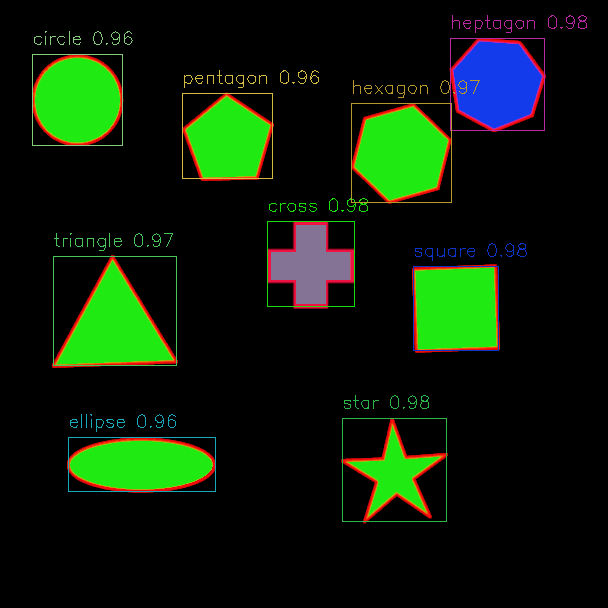


0: 640x640 1 circle, 1 cross, 1 ellipse, 1 heptagon, 1 hexagon, 1 pentagon, 1 square, 1 star, 1 triangle, 327.0ms
Speed: 6.8ms preprocess, 327.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


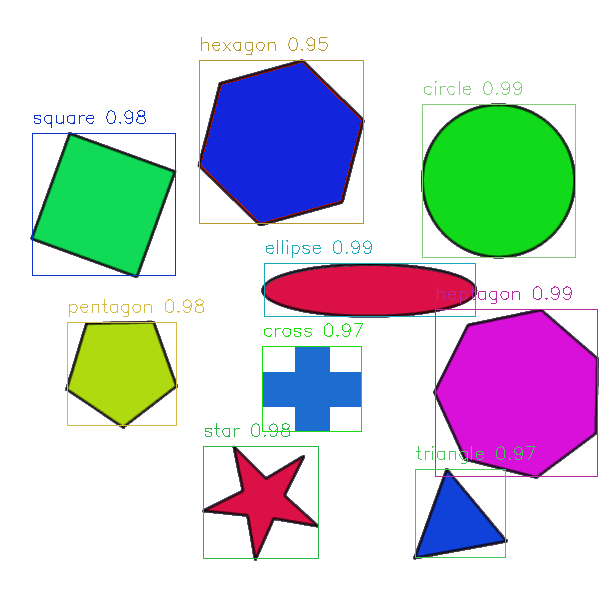

In [ ]:
from google.colab.patches import cv2_imshow

# Processar cada imagem
for image_name in images:
    image_path = os.path.join(image_folder, image_name)
    image, results = process_image(image_path)

    # Desenhar as bounding boxes na imagem
    image_with_boxes = draw_boxes(image, results)

    # Exibir a imagem com as bounding boxes
    #cv2.imshow('Resultado', image_with_boxes)
    cv2_imshow(image_with_boxes)
